# Overall Classification

3 different classification tasks:
* Ecoli
* Coliform
* Ecoli + Coliform

Classes are defined through thresholds

# BEAR IN MIND

* **Precision**: How many of our predictions are correct? Precision is the ability of a classifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

* **Recall**: How well do you notice the phenomenon? Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

* **F1 score**: The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

* **Support**: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
data_path = os.path.join("..", "..", "data")

dir_store_path = os.path.join(data_path, "temporary results")

full_dataset_path = os.path.join(dir_store_path, "overall_dataset.xlsx")

# Load Data

In [99]:
full_df = pd.read_excel(full_dataset_path)

In [100]:
full_df.columns.to_list()

['DateTime',
 'Site',
 'Technician Water Quality',
 'Technician Counting',
 'Temp C_mean',
 'Temp C_std',
 'Ph_mean',
 'Ph_std',
 'Cond (ms)_mean',
 'Cond (ms)_std',
 'Coliform (1ml)_mean',
 'Coliform (1ml)_std',
 'Ecoli (1ml)_mean',
 'Ecoli (1ml)_std',
 'cso_hinterland',
 'cso_middle',
 'cso_sea',
 'rained',
 'mean_rainfall',
 'tide_value',
 'bacteria_sum']

In [101]:
full_df = full_df[full_df["DateTime"] > "2023-04-01"]

In [102]:
full_df = full_df.drop(
    columns=[
        "Site",
        "Technician Water Quality",
        "Technician Counting",
        "Temp C_std",
        "Ph_std",
        "Cond (ms)_std",
        "Coliform (1ml)_std",
        "Ecoli (1ml)_std",
    ]
)

# E. Coli

In [103]:
ecoli_df = full_df.drop(columns=["bacteria_sum", "Coliform (1ml)_mean"])

<Axes: xlabel='Ecoli (1ml)_mean', ylabel='Count'>

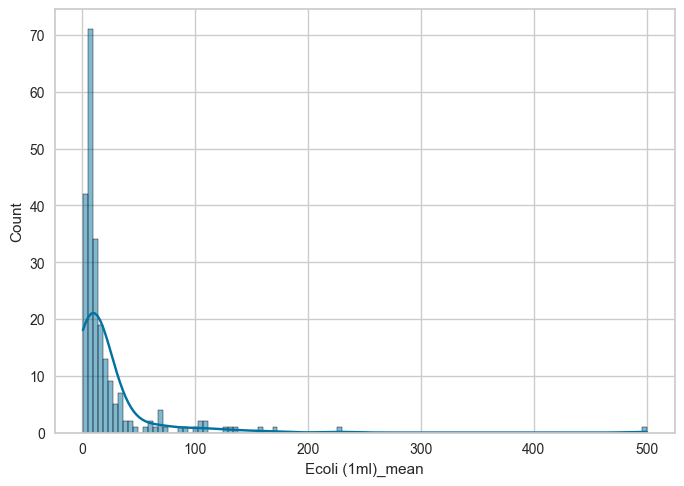

In [104]:
sns.histplot(ecoli_df["Ecoli (1ml)_mean"], kde=True)

In [105]:
# scale to log scale
ecoli_df["Ecoli (1ml)_mean"] = np.log10(ecoli_df["Ecoli (1ml)_mean"])

<Axes: xlabel='Ecoli (1ml)_mean', ylabel='Count'>

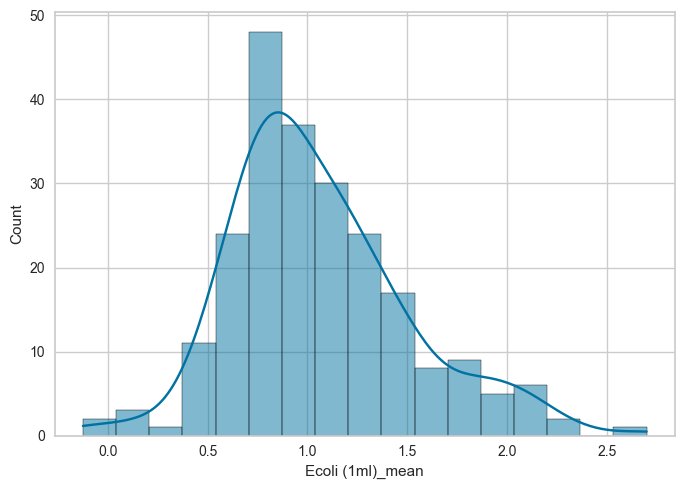

In [106]:
sns.histplot(ecoli_df["Ecoli (1ml)_mean"], kde=True)

## Define classes

In [107]:
print('Threshold:', 10 ** ecoli_df["Ecoli (1ml)_mean"].quantile(0.5))

Threshold: 9.75


In [108]:
# define function to classify ecoli levels based on quartiles
def ecoli_level(ecoli):
    if ecoli <= ecoli_df["Ecoli (1ml)_mean"].quantile(0.5):
        return "Low"
    else:
        return "High"

In [109]:
# define classes for Ecoli based on quantiles
ecoli_df["Class"] = ecoli_df["Ecoli (1ml)_mean"].apply(ecoli_level)

ecoli_df.drop(columns=["Ecoli (1ml)_mean"], inplace=True)

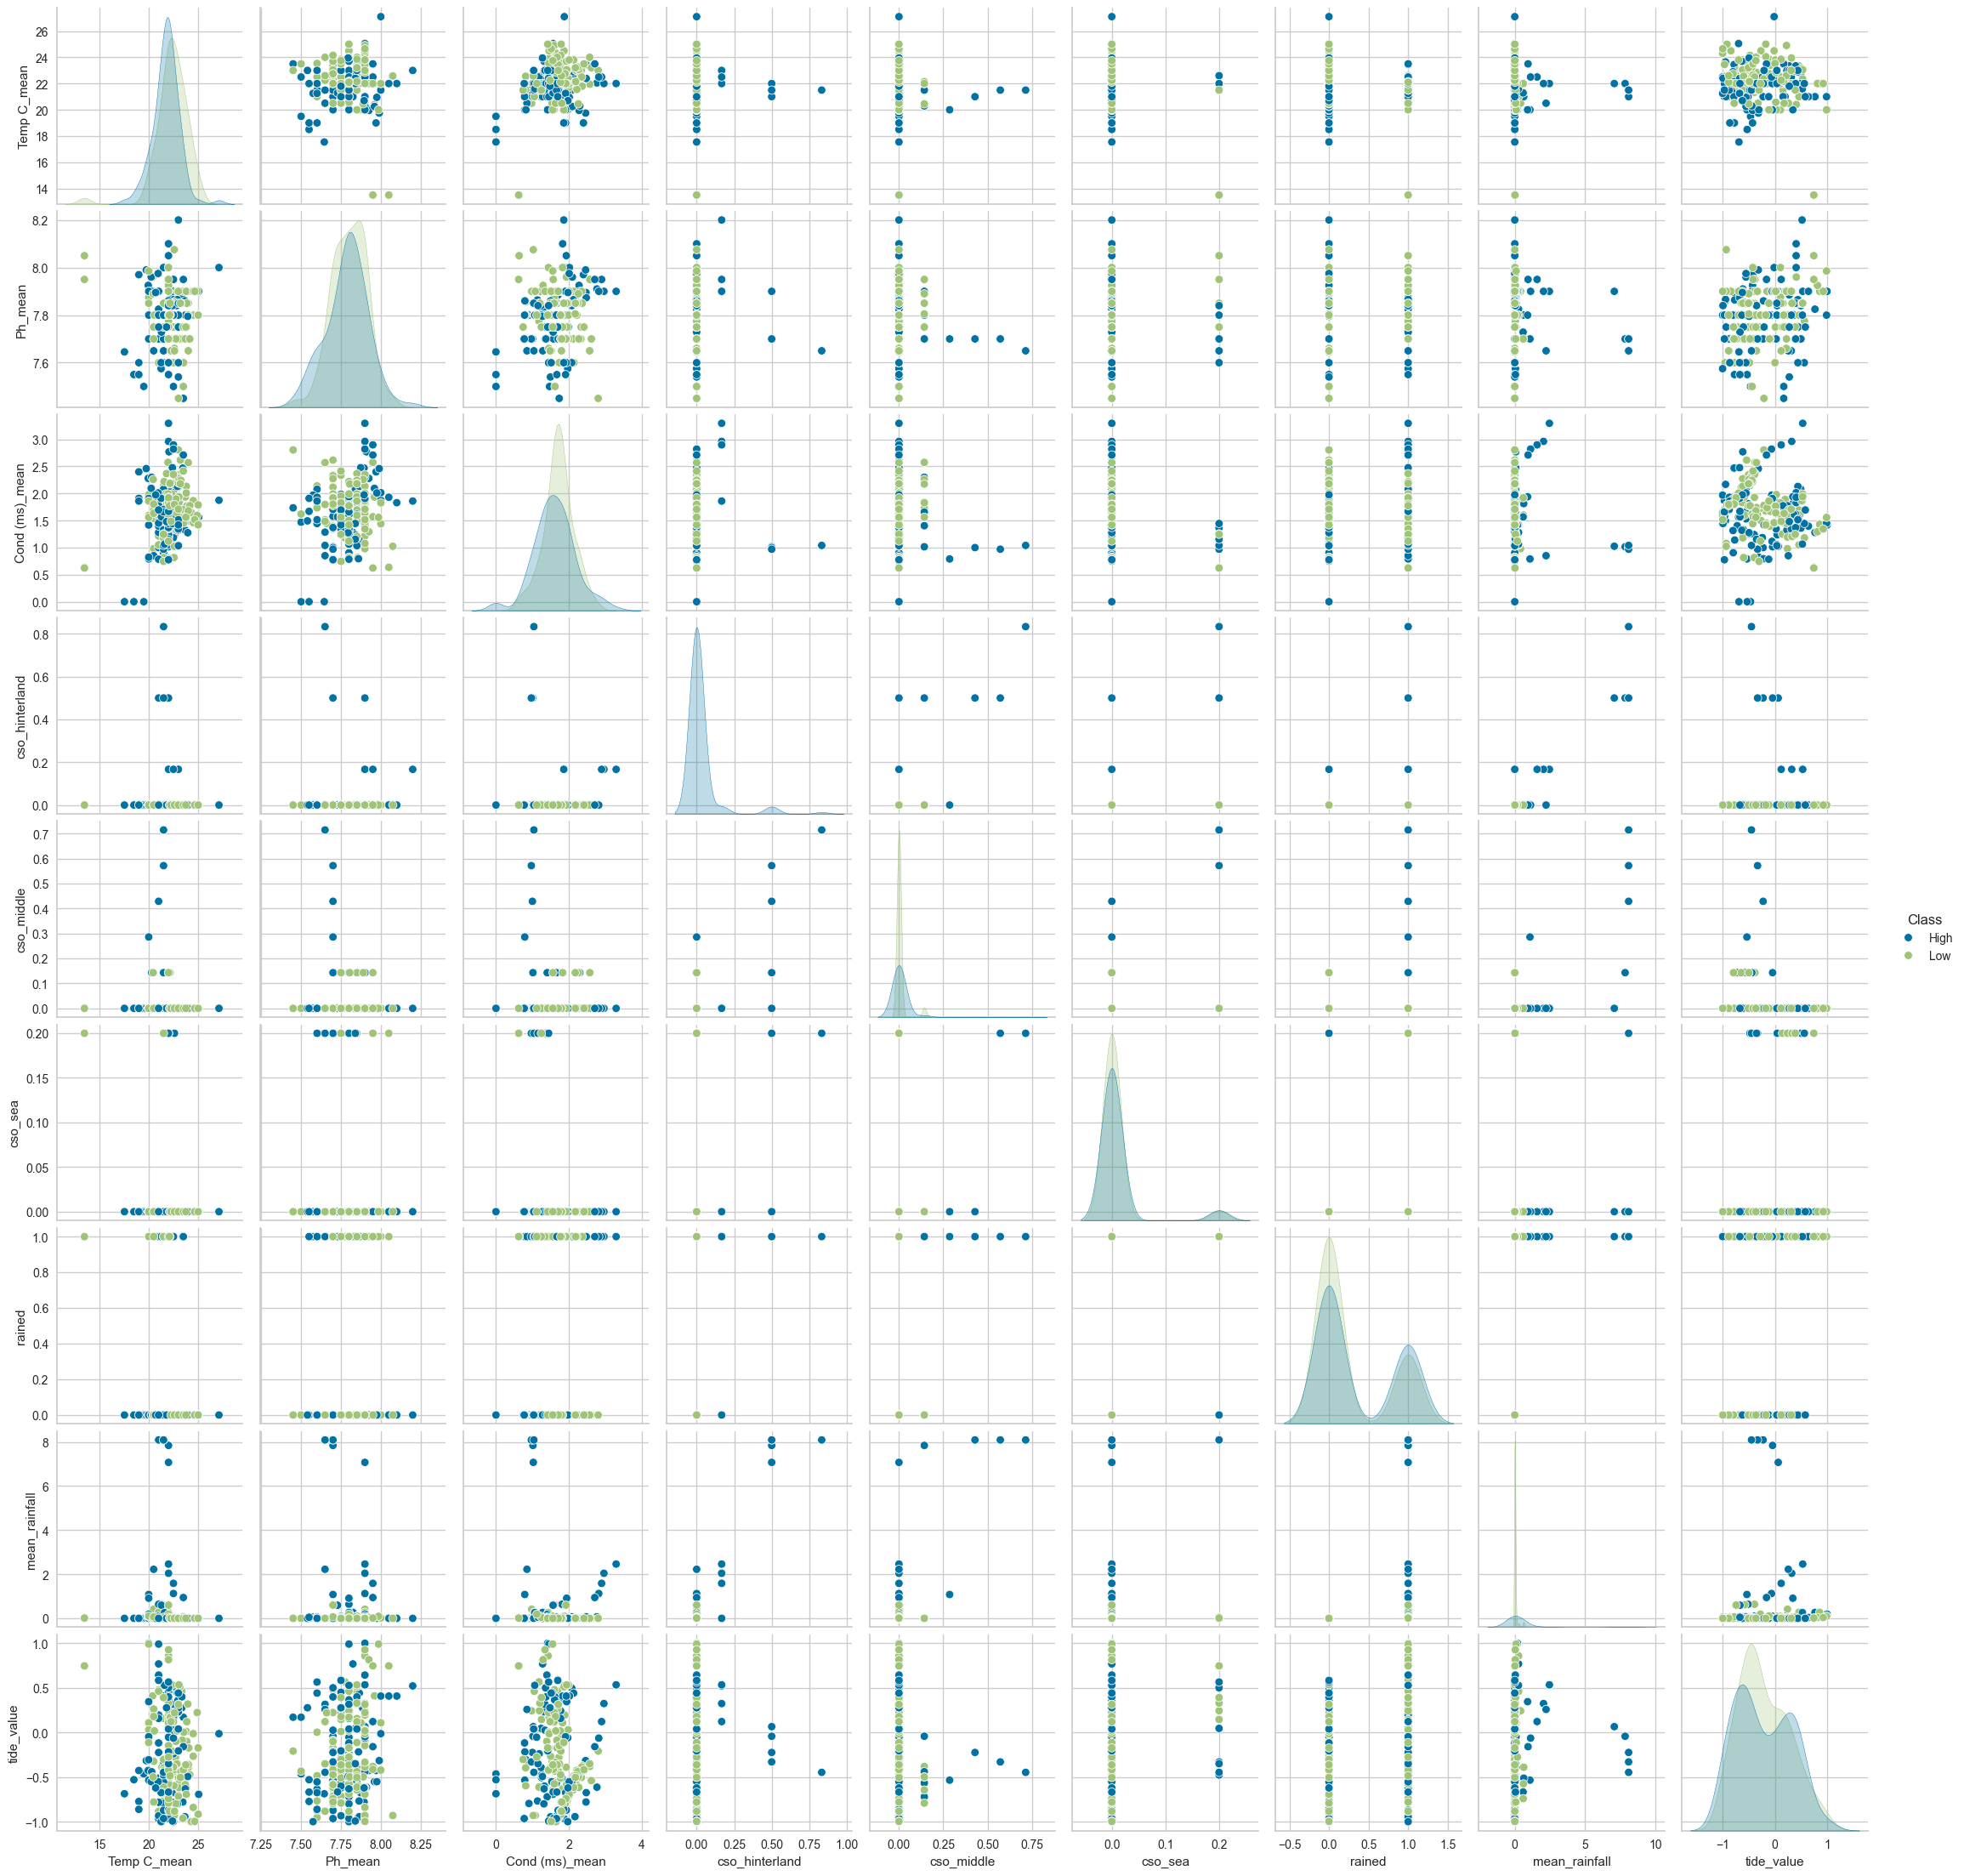

In [110]:
sns.pairplot(ecoli_df, hue="Class")

In [111]:
# count number of samples in each class
ecoli_df["Class"].value_counts()

Class
Low     118
High    110
Name: count, dtype: int64

In [112]:
boxplot_columns = [
    "Temp C_mean",
    "Ph_mean",
    "Cond (ms)_mean",
]

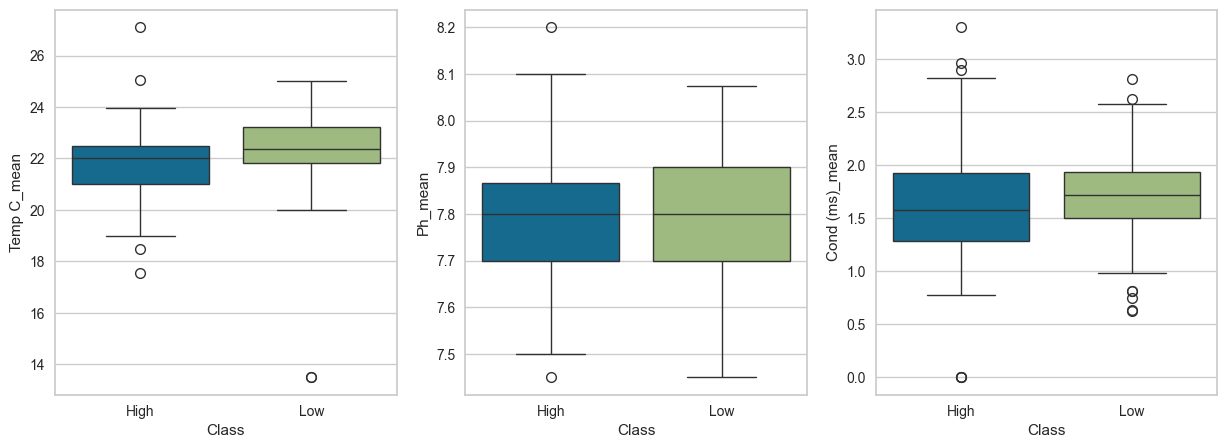

In [113]:
# boxplots of each parameter by class
fig, axs = plt.subplots(1, len(boxplot_columns), figsize=(15, 5))
for col in boxplot_columns:
    sns.boxplot(x="Class", y=col, data=ecoli_df, ax=axs[boxplot_columns.index(col)], hue="Class")
plt.show()

# Perform Classification

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

In [115]:
ecoli_df.isna().sum()

DateTime          0
Temp C_mean       0
Ph_mean           0
Cond (ms)_mean    0
cso_hinterland    0
cso_middle        0
cso_sea           0
rained            0
mean_rainfall     0
tide_value        0
Class             0
dtype: int64

In [116]:
X = ecoli_df.drop(
    columns=[
        "DateTime",
        "Class",
    ]
).copy()
y = ecoli_df["Class"].copy()

y = y.map({"Low": 0, "High": 1})

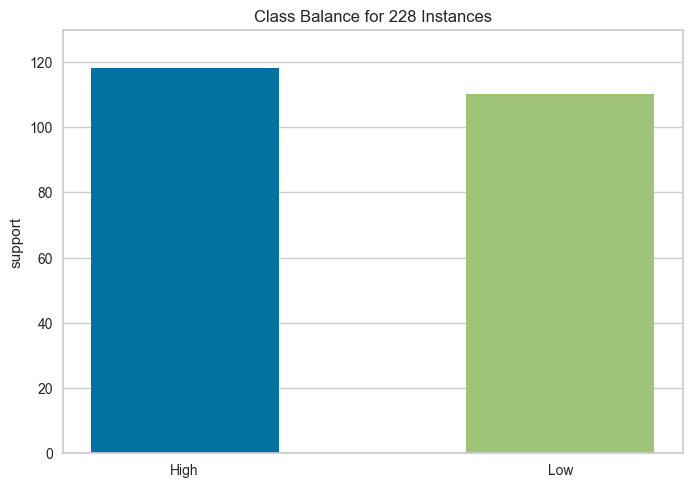

<Axes: title={'center': 'Class Balance for 228 Instances'}, ylabel='support'>

In [117]:
from yellowbrick.classifier import (
    ClassificationReport,
    ROCAUC,
    ClassPredictionError,
    ConfusionMatrix,
    PrecisionRecallCurve,
    ClassBalance,
)


classes = ecoli_df["Class"].unique()

visualizer = ClassBalance(labels=classes)
visualizer.fit(y)
visualizer.show()

# Feature Selection

In [118]:
import warnings
from sklearn import model_selection

In [119]:
%%script false --no-raise-error
from sklearn.feature_selection import SequentialFeatureSelector

selected_features = []

models = [
    LogisticRegression(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(),
    LinearSVC(),
    SGDClassifier(),
    xgb.XGBClassifier(),
]

warnings.filterwarnings("ignore")

for model in models:
    print("=" * 80)
    print(model)
    print("=" * 80)
    print()

    cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

    for direction in ["forward", "backward"]:
        print("Direction:", direction)
        print()
        sfs = SequentialFeatureSelector(
            model, n_features_to_select="auto", direction=direction, cv=cv
        )
        sfs.fit(X, y)
        print(X.columns[sfs.get_support()])
        print("-" * 10)

        selected_features.append(X.columns[sfs.get_support()].to_list())


# get the most common features
from collections import Counter

selected_features = Counter(
    [feature for sublist in selected_features for feature in sublist]
)

In [120]:
selected_features

Counter({'Ph_mean': 14,
         'mean_rainfall': 13,
         'Temp C_mean': 10,
         'Cond (ms)_mean': 9,
         'rained': 9,
         'cso_middle': 9,
         'cso_sea': 8,
         'cso_hinterland': 5,
         'tide_value': 4})

In [121]:

# Comment this line to keep all features

# Drop the features that are not selected at least half of the times

X.drop(
    columns=[
        "Cond (ms)_mean",
        "Ph_mean",
        "Temp C_mean",
        "tide_value",
    ],
    inplace=True,
)

In [122]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

columns = X.columns.to_list()

X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=columns)

# Model Selection

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
)

In [124]:
import optuna

In [125]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier",
        [
            "RandomForest",
            "XGBoost",
            "LogisticRegression",
            "SVC",
            "KNN",
            "DecisionTree",
            "GaussianNB",
            "LinearSVC",
            "SGDClassifier",
        ],
    )

    if classifier_name == "RandomForest":
        model = RandomForestClassifier(
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        model = xgb.XGBClassifier(
            random_state=42,
        )

    elif classifier_name == "LogisticRegression":
        model = LogisticRegression(
            random_state=42,
        )

    elif classifier_name == "SVC":
        model = SVC(
            random_state=42,
        )

    elif classifier_name == "KNN":
        model = KNeighborsClassifier()

    elif classifier_name == "DecisionTree":
        model = DecisionTreeClassifier(
            random_state=42,
        )

    elif classifier_name == "GaussianNB":
        model = GaussianNB()

    elif classifier_name == "LinearSVC":
        model = LinearSVC(
            random_state=42,
        )

    elif classifier_name == "SGDClassifier":
        model = SGDClassifier(
            random_state=42,
        )

    else:
        raise ValueError("Invalid classifier name")

    cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X_train, y=y_train, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [126]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///ecoli.sqlite3",
    study_name=f"Model Selection - Ecoli - Overall - All Data",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-14 12:57:12,999] Using an existing study with name 'Model Selection - Ecoli - Overall - All Data' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-14 12:57:13,315] Trial 200 finished with value: 0.47674137320194887 and parameters: {'classifier': 'RandomForest'}. Best is trial 14 with value: 0.5953074250724829.
[I 2024-03-14 12:57:13,576] Trial 201 finished with value: 0.47674137320194887 and parameters: {'classifier': 'RandomForest'}. Best is trial 14 with value: 0.5953074250724829.
[I 2024-03-14 12:57:13,836] Trial 202 finished with value: 0.47674137320194887 and parameters: {'classifier': 'RandomForest'}. Best is trial 14 with value: 0.5953074250724829.
[I 2024-03-14 12:57:14,105] Trial 203 finished with value: 0.47674137320194887 and parameters: {'classifier': 'RandomForest'}. Best is trial 14 with value: 0.5953074250724829.
[I 2024-03-14 12:57:14,367] Trial 204 finished with value: 0.47674137320194887 and parameters: {'classifier': 'RandomForest'}. Best is trial 14 with value: 0.5953074250724829.
[I 2024-03-14 12:57:14,621] Trial 205 finished with value: 0.47674137320194887 and parameters: {'classifier': 'RandomFor

Since the Condunctivity should be proportional with the tide_value, remove the cond.

Leave just mean_rainfall, tide_value, Temp, rained and cso_sea

In [127]:
study.best_params

{'classifier': 'RandomForest'}

# Hyperparameter Tuning

In [128]:
from sklearn import model_selection


def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["RandomForest", "XGBoost"]
    )

    if classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        max_features = trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        )
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            criterion=criterion,
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
        max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
        learning_rate = trial.suggest_float(
            "learning_rate", 0.01, 0.1, log=True
        )
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
        )

    cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X_train, y=y_train, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [129]:
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///ecoli.sqlite3",
    study_name=f"Hyperparameter Tuning - Ecoli - Overall - All",
    load_if_exists=True,
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-14 12:57:35,819] A new study created in RDB with name: Hyperparameter Tuning - Ecoli - Overall - After March - MinMaxScaled


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-14 12:57:37,477] Trial 0 finished with value: 0.46289167950365273 and parameters: {'classifier': 'XGBoost', 'n_estimators': 880, 'max_depth': 13.84583065330796, 'learning_rate': 0.08955356718582198, 'subsample': 0.851320335756047, 'colsample_bytree': 0.7303344855086334}. Best is trial 0 with value: 0.46289167950365273.
[I 2024-03-14 12:57:38,203] Trial 1 finished with value: 0.47118288933428687 and parameters: {'classifier': 'XGBoost', 'n_estimators': 520, 'max_depth': 24.318888441065848, 'learning_rate': 0.02441864540442126, 'subsample': 0.898185603351031, 'colsample_bytree': 0.18136724401242366}. Best is trial 1 with value: 0.47118288933428687.
[I 2024-03-14 12:57:39,841] Trial 2 finished with value: 0.46714541360598927 and parameters: {'classifier': 'RandomForest', 'n_estimators': 680, 'max_depth': 33.27878974181823, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 1 with value: 0.47118288933428687.
[I 2024-03-14 12:57:41,721] Trial 3 finished with value: 0.478

In [130]:
study.best_params

{'classifier': 'XGBoost',
 'n_estimators': 560,
 'max_depth': 15.871220657395273,
 'learning_rate': 0.010005121739382401,
 'subsample': 0.9302717021822536,
 'colsample_bytree': 0.5405185407874069}

# Model Evaluation

In [131]:
if study.best_params["classifier"] == "RandomForest":
    model = RandomForestClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        max_features=study.best_params["max_features"],
        criterion=study.best_params["criterion"],
        random_state=42,
    )

elif study.best_params["classifier"] == "XGBoost":
    model = xgb.XGBClassifier(
        n_estimators=study.best_params["n_estimators"],
        max_depth=int(study.best_params["max_depth"]),
        learning_rate=study.best_params["learning_rate"],
        subsample=study.best_params["subsample"],
        colsample_bytree=study.best_params["colsample_bytree"],
        random_state=42,
    )

**Warning Note** on inappropriate usage of cross_val_predict

The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalization error.

In [132]:
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

# perform cross-validation and store the results
y_pred = model_selection.cross_val_predict(
    model, X, y, cv=cv
)

y_pred_proba = model_selection.cross_val_predict(
    model, X, y, cv=cv, method="predict_proba"
)

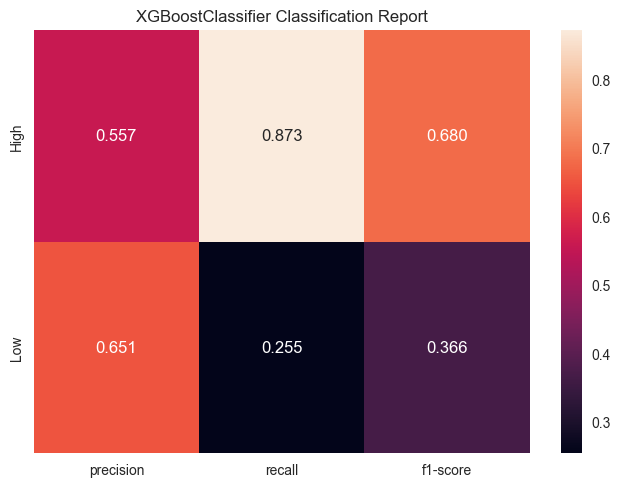

In [133]:
from sklearn.metrics import classification_report


model_name = "XGBoostClassifier"

report = classification_report(y, y_pred, target_names=classes, output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :-3].T, annot=True, fmt=".3f")

plt.title(f"{model_name} Classification Report")
plt.show()

In [134]:
# accuracy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy_score(y, y_pred)

0.5745614035087719

In [135]:
f1_score(y, y_pred, average="weighted")

0.5284467559243025

In [136]:
precision_score(y, y_pred, average="weighted")

0.6023035275177258

In [137]:
recall_score(y, y_pred, average="weighted")

0.5745614035087719

In [138]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_score(y, y_pred_proba[:, 1])

0.5207241910631741

<Figure size 1000x1000 with 0 Axes>

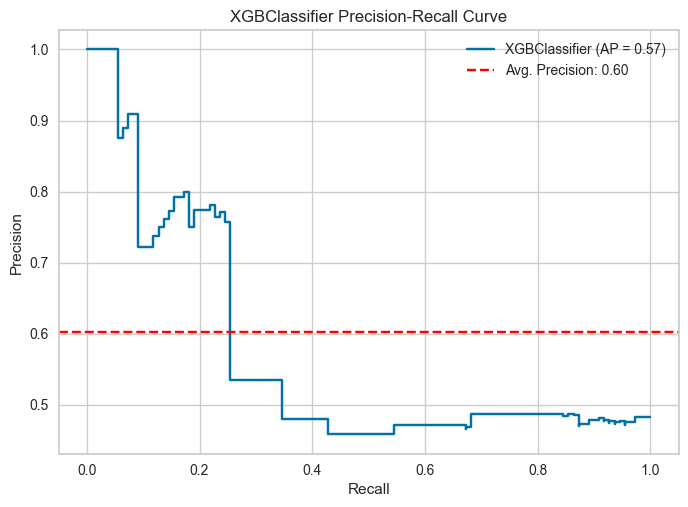

In [139]:
from sklearn.metrics import PrecisionRecallDisplay, precision_score

plt.figure(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y, y_pred_proba[:, 1], name=f"{model.__class__.__name__}")

# plot avg precision
avg_precision = precision_score(y, y_pred, average="weighted")


plt.axhline(avg_precision, color="red", linestyle="--", label=f"Avg. Precision: {avg_precision:.2f}")

plt.setp(plt.gca(), xlabel="Recall", ylabel="Precision")

plt.title(f"{model.__class__.__name__} Precision-Recall Curve")

plt.legend()

plt.show()


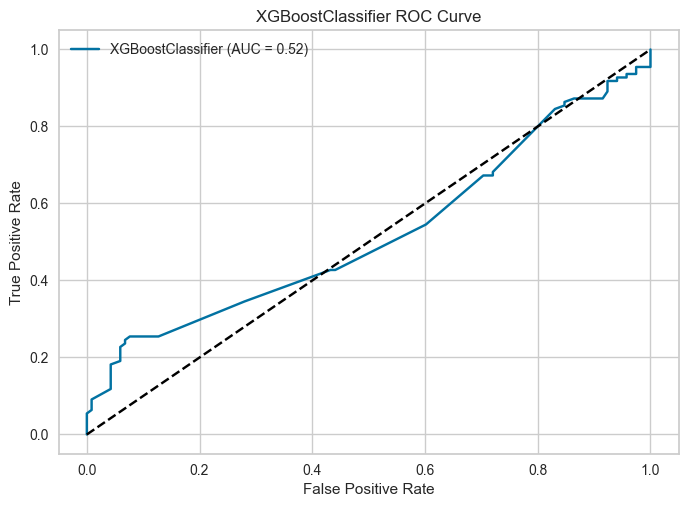

In [140]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_predictions(y, y_pred_proba[:, 1], pos_label=1, name=f"{model_name}")

sns.lineplot(
    x=[0, 1],
    y=[0, 1],
    color="black",
    linestyle="--",
)

plt.setp(plt.gca(), xlabel="False Positive Rate", ylabel="True Positive Rate")

plt.title(f"{model_name} ROC Curve")

plt.show()

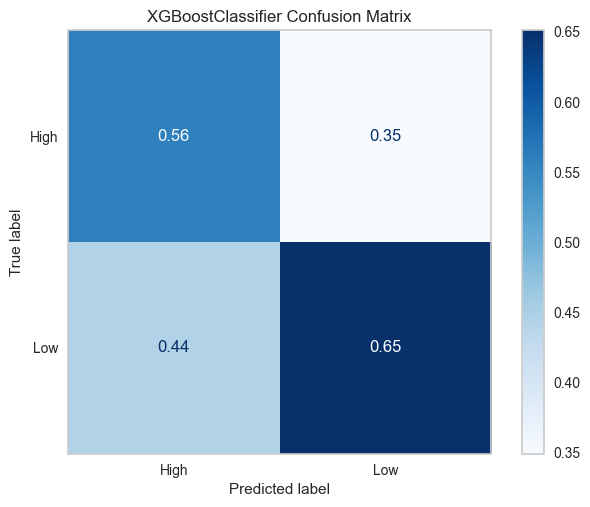

In [141]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    display_labels=classes,
    normalize="pred",
    cmap="Blues",
)

plt.grid(False)

plt.title(f"{model_name} Confusion Matrix")

plt.show()



In [142]:
# cross validation of model
cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)

# perform cross-validation and store the results
results = model_selection.cross_validate(
    model, X, y, cv=cv, return_estimator=True, scoring="f1_weighted"
)

In [143]:
importances = []

for estimator in results["estimator"]:
    importance = estimator.feature_importances_
    importances.append(importance)

In [144]:
importances = np.array(importances)

importances = importances.mean(axis=0)

importances = pd.Series(importances, index=X.columns)

importances = importances.sort_values(ascending=False)

<Axes: xlabel='None', ylabel='None'>

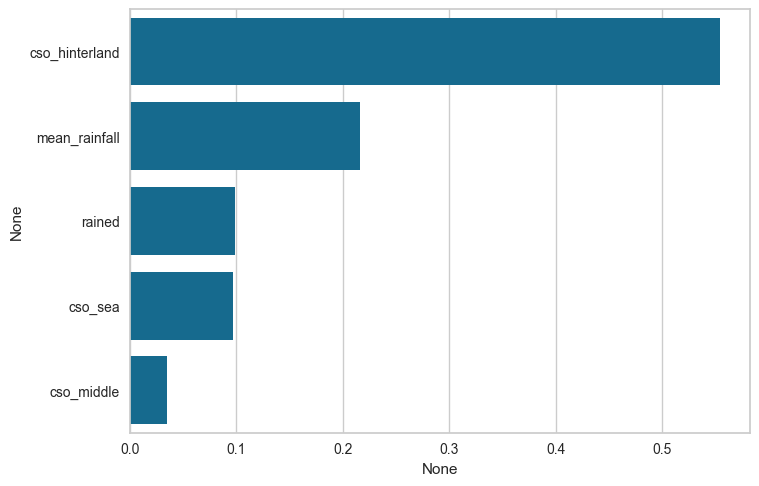

In [145]:
sns.barplot(x=importances, y=importances.index)

# Iteratively Redo Everything with selected model

In [ ]:
%% script false --no-raise-error
model = xgb.XGBClassifier(
    n_estimators=study.best_params["n_estimators"],
    max_depth=int(study.best_params["max_depth"]),
    learning_rate=study.best_params["learning_rate"],
    subsample=study.best_params["subsample"],
    colsample_bytree=study.best_params["colsample_bytree"],
    random_state=42,
)


cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)

for direction in ["forward", "backward"]:
    print("Direction:", direction)
    print()
    sfs = SequentialFeatureSelector(
        model, n_features_to_select="auto", direction=direction, cv=cv
    )
    sfs.fit(X, y)
    print(X.columns[sfs.get_support()])
    print("-" * 10)
    

In [ ]:
%% script false --no-raise-error
# Drop the features that are not selected at least half of the times

# Comment this line to keep all features
# %%script false --no-raise-error

X_selected = X.drop(
    columns=[
        "cso_sea",
        "cso_hinterland",
        "cso_middle",
    ]
)

In [ ]:
%% script false --no-raise-error
from sklearn import model_selection


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, 10)
    max_depth = int(trial.suggest_float("max_depth", 10, 100, log=True))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
    )

    cv = model_selection.KFold(n_splits=20, shuffle=True, random_state=42)
    results = model_selection.cross_val_score(
        estimator=model, X=X, y=y, cv=cv, scoring="f1_weighted"
    )
    return results.mean()

In [ ]:
%% script false --no-raise-error
study = optuna.create_study(
    direction="maximize",
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2024-03-04 17:44:02,988] A new study created in memory with name: no-name-0f24347e-248e-4d84-b62d-d2b5b99f6840


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-03-04 17:44:08,441] Trial 0 finished with value: 0.6395339745823492 and parameters: {'n_estimators': 860, 'max_depth': 17.937092572013466, 'learning_rate': 0.017379433248035595, 'subsample': 0.12450465263840199, 'colsample_bytree': 0.38137139245066753}. Best is trial 0 with value: 0.6395339745823492.
[I 2024-03-04 17:44:13,340] Trial 1 finished with value: 0.6462843623524739 and parameters: {'n_estimators': 320, 'max_depth': 40.64523471043689, 'learning_rate': 0.011433035601474616, 'subsample': 0.7933215764194306, 'colsample_bytree': 0.5763198683089524}. Best is trial 1 with value: 0.6462843623524739.
[I 2024-03-04 17:44:16,078] Trial 2 finished with value: 0.6567810620751798 and parameters: {'n_estimators': 260, 'max_depth': 20.601779291096996, 'learning_rate': 0.0534655982653228, 'subsample': 0.4416828007001221, 'colsample_bytree': 0.9075530818378332}. Best is trial 2 with value: 0.6567810620751798.
[I 2024-03-04 17:44:19,192] Trial 3 finished with value: 0.6668745809573984 a

KeyboardInterrupt: 